In [1]:
import numpy as np
import matplotlib.pyplot as plt
import collections
from mpl_toolkits.mplot3d import Axes3D
#%matplotlib notebook
%matplotlib inline

# MCMC Hill Climbing


## Gaussian Distribution

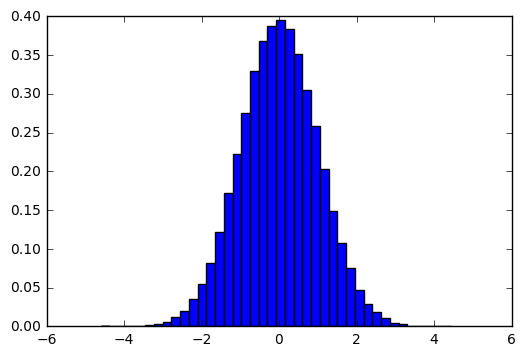

In [2]:
#start with building a gaussian distribution
def box_muller(rand1,rand2,sigma,mu):
    '''Take in two uniform random number from [0,1].
    Make Gaussian using standard deviation sigma and shift mu.
    More info at: https://en.wikipedia.org/wiki/Box%E2%80%93Muller_transform'''
    
    z = np.sqrt(-2*np.log(rand1))*np.cos(2*np.pi*rand2)
    
    #now scale by standard deviation and shift
    z = z*sigma + mu
    
    return z

#lets do a little test of it to make sure it's working properly
test_box = box_muller(np.random.rand(100000),np.random.rand(100000),1,0)

plt.hist(test_box,bins=40,normed =True)
plt.show()

## Simulated Annealing in 1D

In [3]:
#Because there are SO MANY PARAMATERS it's just easier to build a class that takes
#them all in and then we can 

class sim_ann:
    
    def __init__(self,initial_temp,final_temp,temp_sched,initial_pos,hill,sweeps,sigma,minima=False,full_chain=False,boundary=None):
        #import the parameters

        #these are all the parameters we need to get
        #we have a starting and final temperature
        self.initial_temp = initial_temp
        self.final_temp = final_temp
        #a function to calculate the current temperature
        self.temp_sched = temp_sched
        #a starting position
        self.initial_pos = initial_pos
        #the hill we want to climb
        self.hill = hill
        #how many times we want to run at each temperature
        self.sweeps = sweeps
        #sigma for the gaussian
        self.sigma = sigma
        #whether we want to find the max or min
        self.minima = minima
        #whether we want to get just the last element or the entire chain
        self.full_chain = full_chain
        #do we want periodic boundaries
        self.boundary = boundary
        
        #other elements we need

        #this will save us from repeating a chunk of math over and over again
        self.period = None
        
        
        return
    #don't worry about this till later
    def period_rap(self,pos):
        return np.mod(pos-self.boundary[0],self.period)+self.boundary[0]
                      

    def run_sim_ann(self):
        #set the initial conditions
        temp = self.initial_temp
        pos = self.initial_pos
        
        
        #if we have periodic boundary conditions apply them
        if(not self.boundary is None):
            self.period = self.boundary[1]-self.boundary[0]
            self.period_rap(pos)
        
        current_cost = self.hill(pos)

        #if we are finding a minima then we need to flip this
        if(self.minima==True):
            current_cost*=-1

        #check if we want to record the full chain
        if(self.full_chain == True):
            chain = collections.deque([])
            trials = collections.deque([])
            chain.append(pos)
            trials.append(pos)
            

        #we will slowly reduce the temperature till the temperature scheduler stops it
        time = 0
        loop = True
        while loop:

            #do some sweeps at this temperature
            sweep_index = 0
            while sweep_index < self.sweeps:

                #choose a uniform random point 
                rand_pos = box_muller(np.random.random(),np.random.random(),self.sigma,pos)
                
                #if we have a boundary treat it as periodic and wrap around
                if(not self.boundary is None):
                    #loop the rand_pos back
                    rand_pos = self.period_rap(rand_pos)

                #let's compute the cost
                rand_cost = self.hill(rand_pos)

                #flip sign for minimization
                if(self.minima == True):
                    rand_cost  *=-1

                cost = rand_cost - current_cost

                #if this is a clear improvement then jump to that point
                if (cost>=0):
                    #accept change
                    pos = rand_pos
                    current_cost=rand_cost

                    #now try a jump with a temperature change chance
                elif(np.random.random()<np.exp(cost/temp)):
                    pos = rand_pos
                    current_cost=rand_cost

                #add the point to the deque
                if(self.full_chain==True):
                    chain.append(pos)
                    trials.append(rand_pos)

                #track number of sweeps
                sweep_index +=1

            #now we need to reduce the temperature
            temp,loop = self.temp_sched(self.initial_temp,self.final_temp,temp,time)
            time +=1

        #now return the final result

        #if we are asking for the chain then the chain
        if (self.full_chain==True):
            return np.asarray(chain),np.asarray(trials)

        return pos

#now that we got an algorithm for climbing the hill we got to make some temperature schedulers
#They control the temperature of system and when the algorithm will stop
#they can take in a few different parameters to dictate how the system will evolve

#initial_temp and final_temp to get the general start and stop point
#the current temperature and current time step to keep track of what the new temperature should be

#We opted for generator functions because what way each one can have some extra parameters given without passing them through the annealing algorithm

#here are 2 different types:

#linear for a constant decrease
def lin_temp_gen(steps):
    return lambda initial_temp,final_temp,temp,time : (initial_temp*(1-time/steps),not time == steps)

#geometric for a exponential decrease
def geom_temp_gen(steps):
    return lambda initial_temp,final_temp,temp,time : (np.max([initial_temp*(final_temp/initial_temp)**(time/steps),final_temp]),not time==steps)

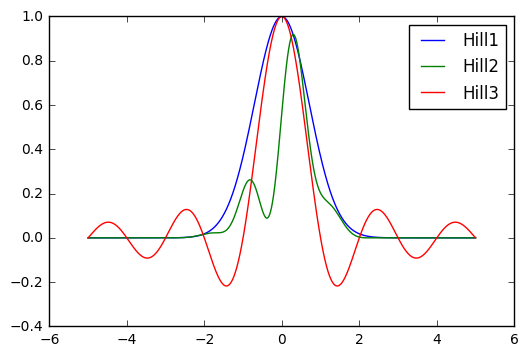

In [4]:
# Now we need some hills to climb:

#standard gaussian shaped hill (max at 0)
hill1 = lambda x : np.exp(-x**2)

#the funky one from the assignment (max at ~0.29)
hill2 = lambda x : 1.0/(2*np.sqrt(np.pi))*(np.sin(5*x)+np.sin(2*x)+2)*np.exp(-x**2)

#sinc function (max at 0)
hill3 = np.sinc

temp_range=np.linspace(-5,5,2000)
plt.plot(temp_range,hill1(temp_range),label='Hill1')
plt.plot(temp_range,hill2(temp_range),label='Hill2')
plt.plot(temp_range,hill3(temp_range),label='Hill3')
plt.legend()
plt.show()

In [5]:
#lets give it a test
sim_hill1 = sim_ann(1,0.000000001,geom_temp_gen(1000),0,hill1,100,1)
sim_hill2 = sim_ann(1,0.000000001,geom_temp_gen(1000),0,hill2,100,1)
sim_hill3 = sim_ann(1,0.000000001,geom_temp_gen(1000),0,hill3,100,1)

hill1_final = sim_hill1.run_sim_ann()
print("hill1: ",hill1_final)
print('target: 0')

hill2_final = sim_hill2.run_sim_ann()
print("hill2: ",hill2_final)
print('target: ~0.29')

hill3_final = sim_hill3.run_sim_ann()
print("hill3: ",hill3_final)
print('target: 0')


#run this block multiple times.
#sometimes you can get a result that’s really off.
#we'll address this later.

hill1:  -452.464894344
target: 0
hill2:  0.296227657425
target: ~0.29
hill3:  9.75659378776e-06
target: 0


In [6]:
#lets write a function to give some in depth analysis on a single run
def gather_full_chain(sim_hill):
    #in case we have the full chain off lets turn it on for a bit
    save_full_chain = sim_hill.full_chain
    sim_hill.full_chain = True
    
    #run the simulation
    chain, trials = sim_hill.run_sim_ann()
    
    #reset the full chain value
    sim_hill.full_chain = save_full_chain 
    
    return chain, trials

#now lets write a function to plot these
def plot_full_chain(chain,trials,sim_hill,point_range=None,y_lim=None,font=None,fig_size=(8,4.5),legend_loc=None):
    %matplotlib inline
    
    #set up the font
    if(not font is None):
        plt.rc('font', **font)
       
    #set up the size
    plt.figure(figsize=fig_size)
    
    #did we look for max or min?
    if(sim_hill.minima == True):
        extrema = 'Minima'
    else:
        extrema = 'Maxima'
    
    #title and axis labels
    plt.title('Simulated Annealing Hill Climb Chain for Global {}'.format(extrema))
    plt.xlabel('step')
    plt.ylabel('position')
    
    #limits
    if(not point_range is None):
        plt.xlim(point_range)
        point_low = point_range[0]
        point_high = point_range[1]
        x_range = np.arange(point_low,point_high)
    else:
        point_low = 0
        point_high = chain.size
        x_range = np.arange(chain.size)
    if(not y_lim is None):
        plt.ylim(y_lim)
        hill_steps = np.linspace(y_lim[0],y_lim[1],2000)
    else:
        plt.ylim([np.min(trials),np.max(trials)])
        hill_steps = np.linspace(np.min(trials),np.max(trials),2000)
    
    #plot the chain and trials
    plt.plot(x_range,trials[point_low:point_high],label='Trial Position',color='b')
    plt.plot(x_range,chain[point_low:point_high],label='Markov Chain Position',color='g')
    plt.plot((sim_hill.hill(hill_steps))*x_range.size+x_range[0],hill_steps,label='Rescaled and Shifted Hill',color='r')
    

    plt.legend(loc=legend_loc)
    plt.show()
        

In [7]:
#lets give it a shot!
sim_hill1 = sim_ann(1,0.000000001,geom_temp_gen(1000),0,hill1,100,1)
sim_hill2 = sim_ann(1,0.000000001,geom_temp_gen(1000),0,hill2,100,1)
sim_hill3 = sim_ann(1,0.000000001,geom_temp_gen(1000),0,hill3,100,1)

chain1, trials1 = gather_full_chain(sim_hill1)
chain2, trials2 = gather_full_chain(sim_hill2)
chain3, trials3 = gather_full_chain(sim_hill3)

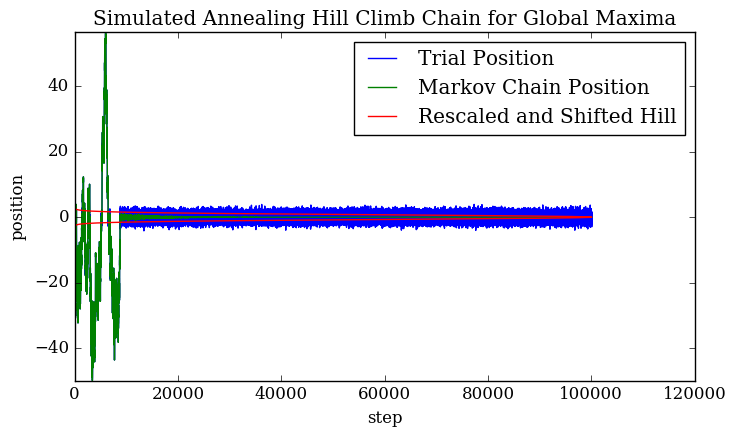

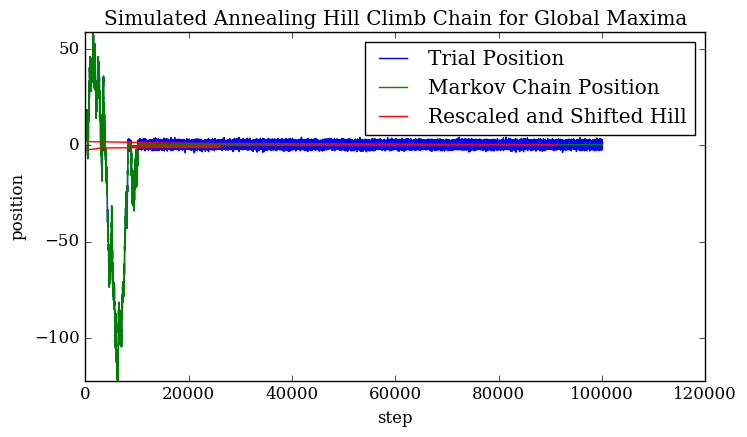

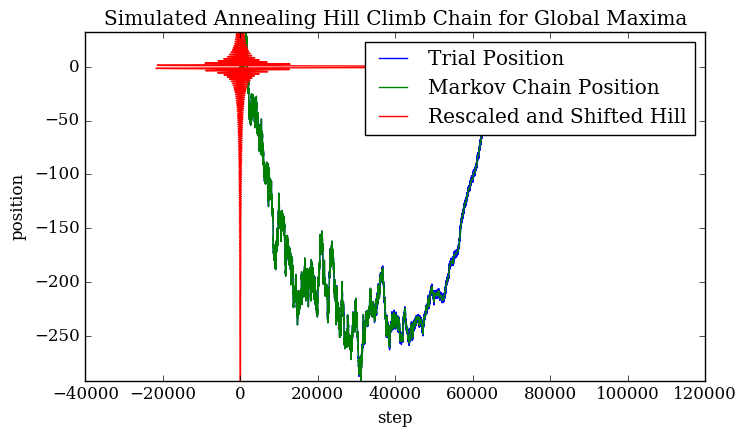

In [8]:
font = {'family' : 'serif',
    'weight' : 'normal',
    'size'   : 12}

plot_full_chain(chain1,trials1,sim_hill1,font=font)
plot_full_chain(chain2,trials2,sim_hill2,font=font)
plot_full_chain(chain3,trials3,sim_hill3,font=font)

In [9]:
#split the function to run gather results from the plotting function so we don't have to wait long

#lets make a function to gather many runs of each one:
def gather_many_runs(runs,sim_hill):
    #in case we have the full chain on lets turn it off for a bit
    save_full_chain = sim_hill.full_chain
    sim_hill.full_chain = False
    
    #now make an array to store results
    results = np.zeros(runs)
    
    for index in range(runs):
        results[index] = sim_hill.run_sim_ann()
    
    #reset the full chain value
    sim_hill.full_chain = save_full_chain
    
    #return the results
    return results

def plot_many_runs(results,sim_hill,x_lim=None,y_lim=None,num_bins=30,font=None,fig_size=(8,4.5)):
    %matplotlib inline
    
    #set up the font
    if(not font is None):
        plt.rc('font', **font)
       
    #set up the size
    plt.figure(figsize=fig_size)
    
    #did we look for max or min?
    if(sim_hill.minima == True):
        extrema = 'Minima'
    else:
        extrema = 'Maxima'
    
    #title and axis labels
    plt.title('Simulated Annealing Hill Climb for Global {}'.format(extrema))
    plt.xlabel('Position')
    plt.ylabel('recorded {} at position'.format(extrema))
    
    #histogram fist
    (hights, bins, patches) = plt.hist(results,bins=num_bins,label='recorded {}'.format(extrema),color='b')
    
    #limits
    if(not x_lim is None):
        plt.xlim(x_lim)
        hill_steps = np.linspace(x_lim[0],x_lim[1],2000)
    elif (not sim_hill.boundary is None):
        plt.xlim(sim_hill.boundary)
        hill_steps = np.linspace(sim_hill.boundary[0],sim_hill.boundary[1],2000)
    else:
        #get the edges for the plot
        first_bin = bins[0]
        last_bin = bins[len(bins)-1]
        hill_steps = np.linspace(first_bin,last_bin,2000)
    if(not y_lim is None):
        plt.ylim(y_lim)
        
    #we want to scale the original function by the bins so we can it if the bins are high
    max_hight = np.max(hights)

    plt.plot(hill_steps,sim_hill.hill(hill_steps)*max_hight,label='rescaled Hill function',color='r')

    plt.legend()
    plt.show()

In [10]:

#lower the temperature schedule runs so this runs 'fast'
sim_hill1.temp_sched = geom_temp_gen(100)
sim_hill2.temp_sched = geom_temp_gen(100)
sim_hill3.temp_sched = geom_temp_gen(100)


results1 = gather_many_runs(100,sim_hill1)
print('finished 1')
results2 = gather_many_runs(100,sim_hill2)
print('finished 2')
results3 = gather_many_runs(100,sim_hill3)
print('finished 3')

finished 1
finished 2
finished 3


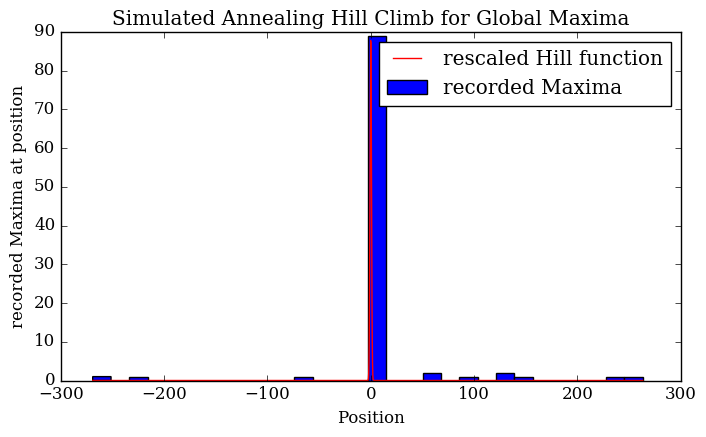

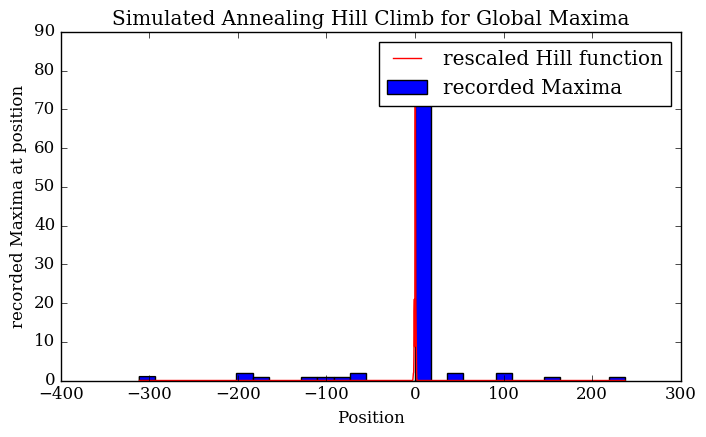

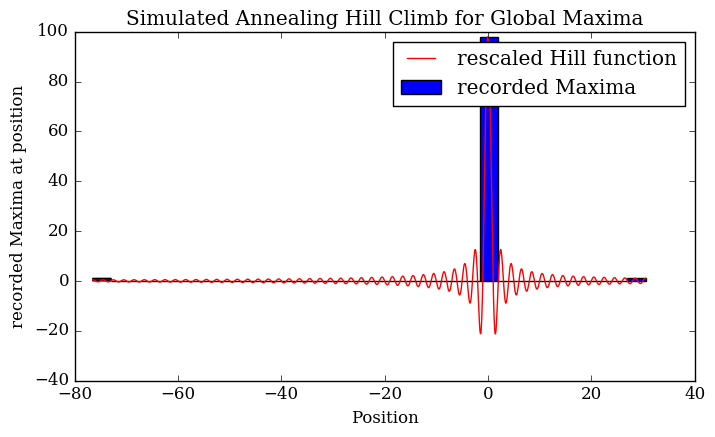

In [11]:
plot_many_runs(results1,sim_hill1,font=font)
plot_many_runs(results2,sim_hill2,font=font)
plot_many_runs(results3,sim_hill3,font=font)

## Plateau problem, Tiny Local Extrema and Boundaries

As you can see from the plots above there is a chance to get stuck far away from the maxima. This is caused by a relatively flat part which makes the transition at high temperature roughly $50:50$ to go up or down. Once the system starts to cool we may get trapped in a tiny local extrema which we will have a hard time leaving. This is really apparent when we start far from the global extrema.

We can mitigate this by starting from a low temperature near are target, a value for sigma that balances moving away with chance of finding a higher peak closer in, or last but not least boundaries.

If we add boundaries for which are walk is confined to then we can narrow down the search space. This allows us to also pick smaller values of sigma and we can even do a rough run before choosing a region to do a more refined search.

The easiest way ensure we don't go past the boundary is to make the boundaries periodic. So when ever we roll out of the boundary we just pop up on the other side.

In [12]:
#now reset and test with boundary conditions
sim_hill1 = sim_ann(100,0.000000001,geom_temp_gen(1000),0,hill1,100,1,boundary=np.array([-4,4]))
sim_hill2 = sim_ann(100,0.000000001,geom_temp_gen(1000),0,hill2,100,1,boundary=np.array([-3,3]))
sim_hill3 = sim_ann(100,0.000000001,geom_temp_gen(1000),0,hill3,100,1,boundary=np.array([-5,5]))

chain1, trials1 = gather_full_chain(sim_hill1)
chain2, trials2 = gather_full_chain(sim_hill2)
chain3, trials3 = gather_full_chain(sim_hill3)

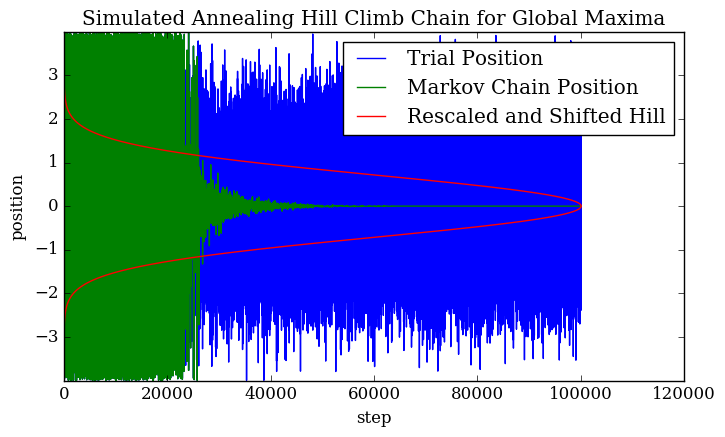

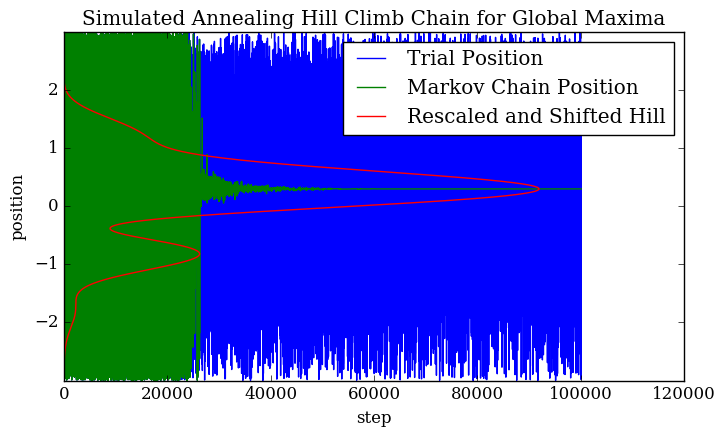

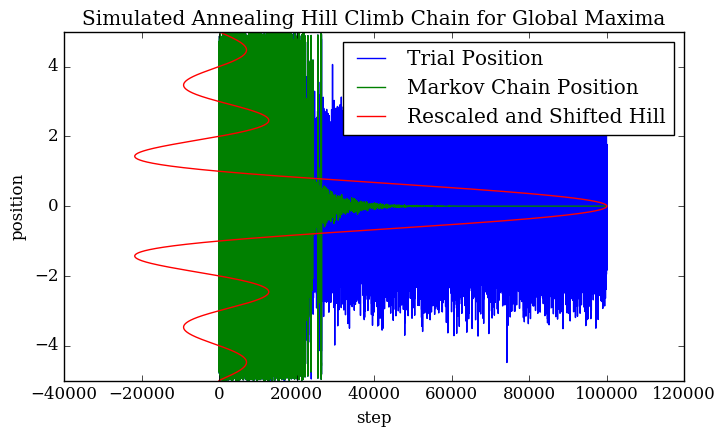

In [13]:
plot_full_chain(chain1,trials1,sim_hill1,font=font)
plot_full_chain(chain2,trials2,sim_hill2,font=font)
plot_full_chain(chain3,trials3,sim_hill3,font=font)

In [14]:
#now over many trials
sim_hill1.temp_sched = geom_temp_gen(100)
sim_hill2.temp_sched = geom_temp_gen(100)
sim_hill3.temp_sched = geom_temp_gen(100)

results1 = gather_many_runs(100,sim_hill1)
print('finished 1')
results2 = gather_many_runs(100,sim_hill2)
print('finished 2')
results3 = gather_many_runs(100,sim_hill3)
print('finished 3')

finished 1
finished 2
finished 3


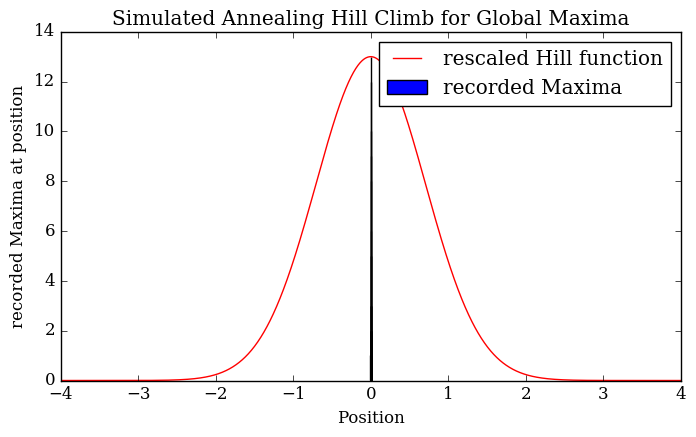

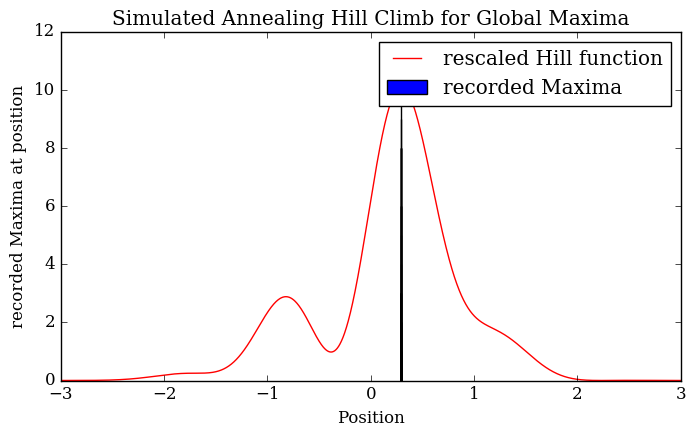

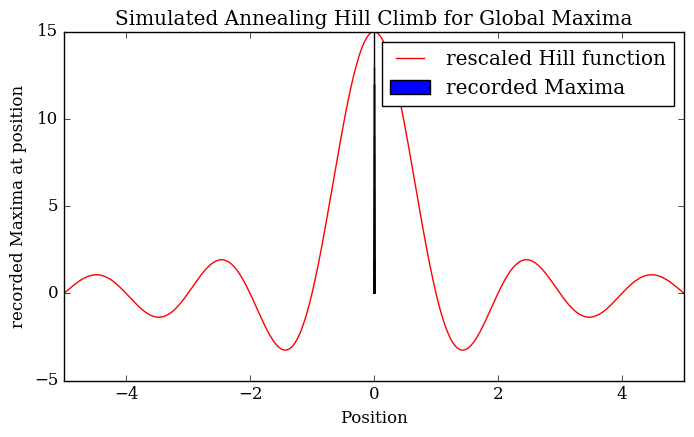

In [15]:
plot_many_runs(results1,sim_hill1,font=font)
plot_many_runs(results2,sim_hill2,font=font)
plot_many_runs(results3,sim_hill3,font=font)

In [16]:
#now lets try and reduce sigma and see what happens
sim_hill1.sigma=0.1
sim_hill2.sigma=0.1
sim_hill3.sigma=0.1

sim_hill1.temp_sched = geom_temp_gen(1000)
sim_hill2.temp_sched = geom_temp_gen(1000)
sim_hill3.temp_sched = geom_temp_gen(1000)

chain1, trials1 = gather_full_chain(sim_hill1)
chain2, trials2 = gather_full_chain(sim_hill2)
chain3, trials3 = gather_full_chain(sim_hill3)

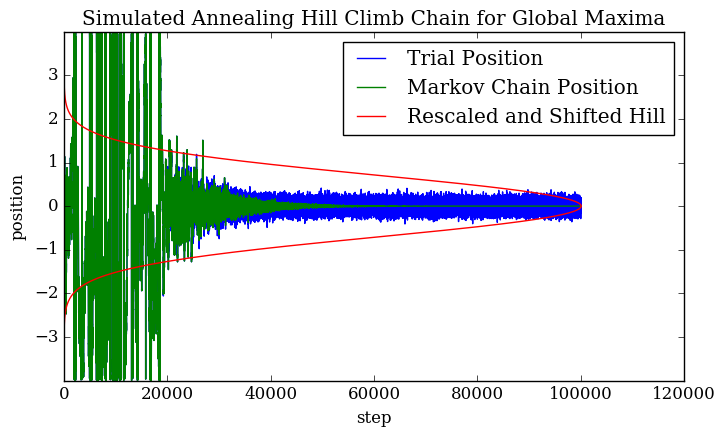

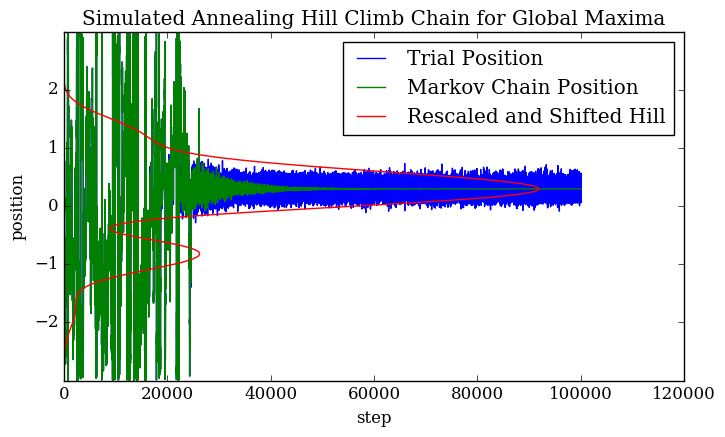

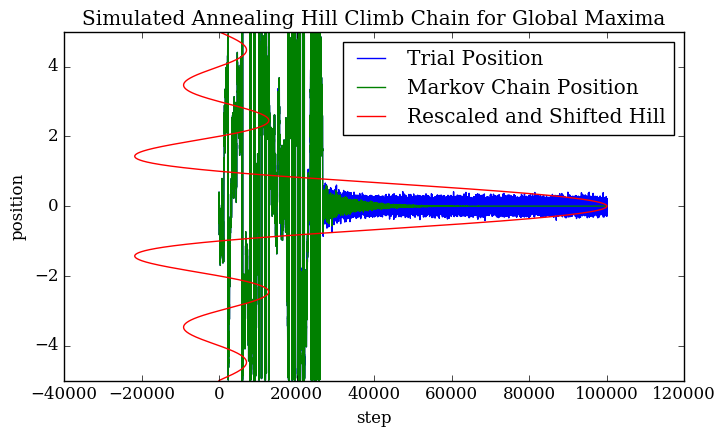

In [17]:
plot_full_chain(chain1,trials1,sim_hill1,font=font)
plot_full_chain(chain2,trials2,sim_hill2,font=font)
plot_full_chain(chain3,trials3,sim_hill3,font=font)

In [18]:
#now over many trials
sim_hill1.temp_sched = geom_temp_gen(100)
sim_hill2.temp_sched = geom_temp_gen(100)
sim_hill3.temp_sched = geom_temp_gen(100)

results1 = gather_many_runs(100,sim_hill1)
print('finished 1')
results2 = gather_many_runs(100,sim_hill2)
print('finished 2')
results3 = gather_many_runs(100,sim_hill3)
print('finished 3')

finished 1
finished 2
finished 3


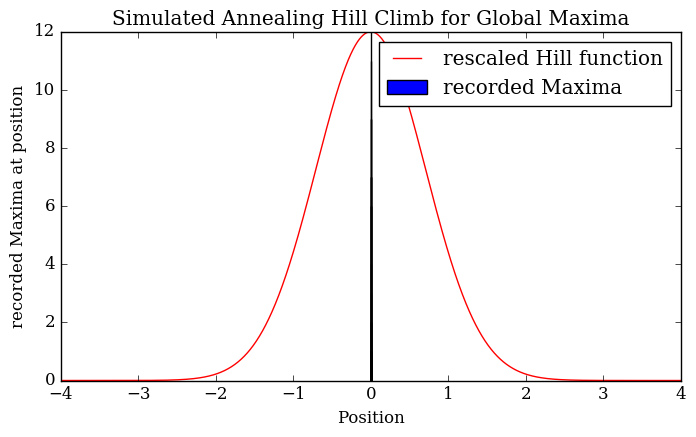

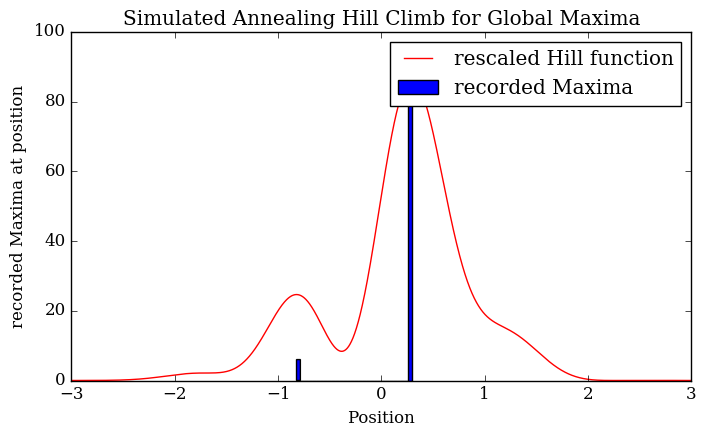

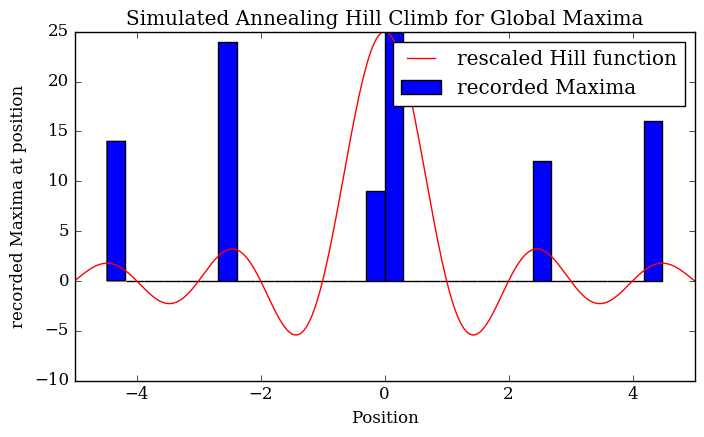

In [19]:
plot_many_runs(results1,sim_hill1,font=font)
plot_many_runs(results2,sim_hill2,font=font)
plot_many_runs(results3,sim_hill3,font=font)

## More Dimensions

So lets add another dimension to the mix. The simulated annealing doesn't change much (the cost function still works the same) so we just need to make it work on 2 or more dimensions for arrays.

In [20]:
class sim_ann_multi:
    
    #same list of parameters
    def __init__(self,initial_temp,final_temp,temp_sched,initial_pos,hill,sweeps,sigma,minima=False,full_chain=False,boundary=None):
        self.initial_temp = initial_temp
        self.final_temp = final_temp
        self.temp_sched = temp_sched
        self.initial_pos = initial_pos
        self.hill = hill
        self.sweeps = sweeps
        self.sigma = sigma
        self.minima = minima
        self.full_chain = full_chain
        self.boundary = boundary
        
        #other elements we need
        self.period = None
        self.zeros = None
        
        return
    
    #little bit of tweaking to get this to work properly.
    #Any dimension with a none zero period is given periodic boundary conditions
    def period_rap(self,pos):
        return np.where(np.not_equal(self.period,self.zeros),np.mod(pos-self.boundary[:,0],self.period)+self.boundary[:,0],pos)



    def run_sim_ann(self):
        #set the initial conditions
        temp = self.initial_temp
        pos = self.initial_pos
        
        #if we have periodic boundary conditions apply them
        if(not self.boundary is None):
            self.period = self.boundary[:,1]-self.boundary[:,0]
            self.zeros = np.zeros(self.initial_pos.size)
            pos = self.period_rap(pos)
            print(pos)
        
        current_cost = self.hill(pos)

        #if we are finding a minima then we need to flip this
        if(self.minima==True):
            current_cost*=-1

        #check if we want to record the full chain
        if(self.full_chain == True):
            chain = collections.deque([])
            trials = collections.deque([])
            chain.append(pos)
            trials.append(pos)
            

        #we will slowly reduce the temperature till the temperature scheduler stops it
        time = 0
        loop =True
        while loop:
            

            #do some sweeps at this temperature
            sweep_index = 0
            while sweep_index < self.sweeps:

                #choose a uniform random point 
                rand_pos = box_muller(np.random.rand(self.initial_pos.size),np.random.rand(self.initial_pos.size),self.sigma,pos)

                #if we have a boundary treat it as periodic and wrap around
                if(not self.boundary is None):
                    #loop the rand_pos back
                    rand_pos = self.period_rap(rand_pos)
                
                #let's compute the cost
                rand_cost = self.hill(rand_pos)

                #flip sign for minimization
                if(self.minima == True):
                    rand_cost  *=-1

                cost = rand_cost - current_cost

                #if this is a clear improvement then jump to that point
                if (cost>=0):
                    #accept change
                    pos = rand_pos
                    current_cost=rand_cost

                    #now try a jump with a temperature change chance
                elif(np.random.random()<np.exp(cost/temp)):
                    pos = rand_pos
                    current_cost=rand_cost

                #add the point to the deque
                if(self.full_chain==True):
                    chain.append(pos)
                    trials.append(rand_pos)

                #track number of sweeps
                sweep_index +=1

            #now we need to reduce the temperature
            temp,loop = self.temp_sched(self.initial_temp,self.final_temp,temp,time)
            time +=1

        #now return the final result

        #if we are asking for the chain then the chain
        if (self.full_chain==True):
            return np.asarray(chain),np.asarray(trials)

        return pos
    

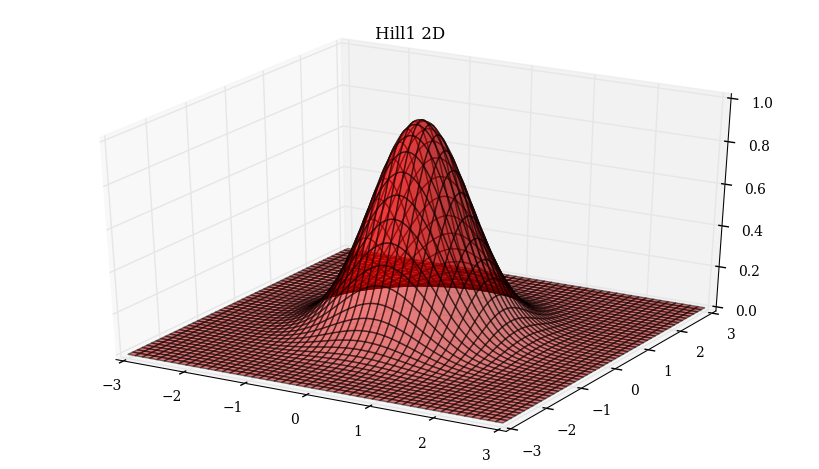

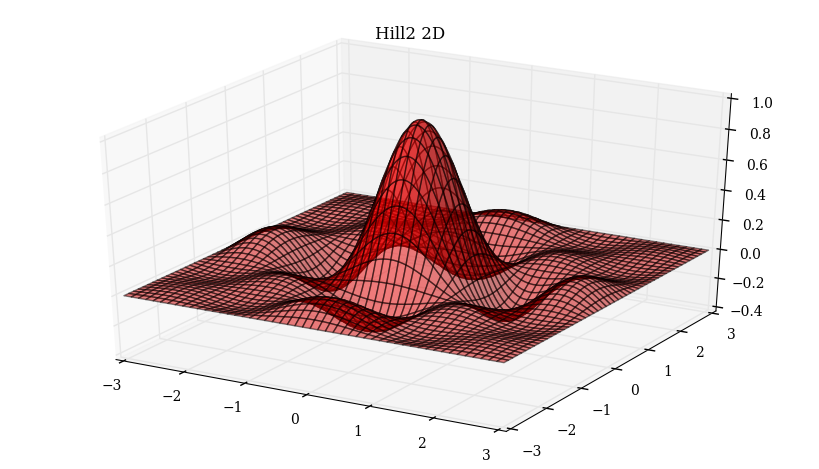

In [21]:
#sum 2D hills to try it on:
hill1_2D = lambda pos : np.exp(-pos[0]**2-pos[1]**2)
hill2_2D = lambda pos : np.sinc(pos[0])*np.sinc(pos[1])

def quick_plot(hill,fig_size=(8,4.5),title=""):
    %matplotlib inline
    
    fig = plt.figure(figsize=fig_size)
    ax = Axes3D(fig)
    
    hill_x = np.linspace(-3,3,500)
    hill_y = hill_x
    
    #plot the function
    hill_z =np.zeros((hill_x.size,hill_y.size))
    index_x=0
    while index_x <hill_x.size:
        index_y=0
        while index_y<hill_y.size:
            hill_z[index_y,index_x]= hill(np.array([hill_x[index_x],hill_y[index_y]]))
            index_y+=1
        index_x +=1
    
    hill_x, hill_y = np.meshgrid(hill_x,hill_y)
    
    ax.set_title(title)

    ax.plot_surface(hill_x,hill_y,hill_z,alpha=0.5,color='r')

    #ax.set_legend(loc=legend_loc)
    plt.show(fig)
    
quick_plot(hill1_2D,title="Hill1 2D")
quick_plot(hill2_2D,title="Hill2 2D")

In [22]:
#now lets test it
sim_hill1_2D = sim_ann_multi(100,0.000000001,geom_temp_gen(100),np.array([0,0]),hill1_2D,50,1)
sim_hill2_2D = sim_ann_multi(100,0.000000001,geom_temp_gen(100),np.array([0,0]),hill2_2D,50,1)

hill1_final_2D = sim_hill1_2D.run_sim_ann()
print("hill1: ",hill1_final_2D)
print('target: [ 0 0]')

hill2_final_2D = sim_hill2_2D.run_sim_ann()
print("hill2: ",hill2_final_2D)
print('target: [ 0 0]')

hill1:  [ 0.0002206  -0.05130595]
target: [ 0 0]
hill2:  [-74.46711403 -38.45089748]
target: [ 0 0]


This can be wildly off because with the increase in dimensions comes an increase in the chance of going into an unfavorable direction.

In [23]:
#now lets plot this out and find out what going on
def plot_full_chain_2D(chain,trials,sim_hill,x_lim=None,y_lim=None,point_range=None,font=None,fig_size=(8,4.5),legend_loc=None):
    
    #use less points as this gets really ugly looking.
    
    #%matplotlib qt
    %matplotlib inline
    
    #set up the font
    if(not font is None):
        plt.rc('font', **font)
       
    #set up the size
    fig = plt.figure(figsize=fig_size)
    ax = Axes3D(fig)
    
    #did we look for max or min?
    if(sim_hill.minima == True):
        extrema = 'Minima'
    else:
        extrema = 'Maxima'
    
    #title and axis labels
    ax.set_title('Simulated Annealing Hill Climb Chain for Global {}'.format(extrema))
    
    ax.set_xlabel('x Position')
    ax.set_ylabel('y Position')
    ax.set_zlabel('Step')
    
    #limits
    grid_size= 300
    if(not x_lim is None):
        ax.set_xlim(x_lim)
        hill_x = np.linspace(x_lim[0],x_lim[1],grid_size)
    else:
        ax.set_xlim([np.min(trials[:,0]),np.max(trials[:,0])])
        hill_x = np.linspace(np.min(trials[:,0]),np.max(trials[:,0]),grid_size)
        
    if(not y_lim is None):
        ax.set_ylim(y_lim)
        hill_y = np.linspace(y_lim[0],y_lim[1],grid_size)
    else:
        ax.set_ylim([np.min(trials[:,1]),np.max(trials[:,1])])
        hill_y = np.linspace(np.min(trials[:,1]),np.max(trials[:,1]),grid_size)
    if(not point_range is None):
        ax.set_zlim(point_range)
        point_low = point_range[0]
        point_high = point_range[1]
    else:
        point_low = 0
        point_high =trials[:,0].size
        
    z_range = np.arange(point_low,point_high)
    
    #plot the markov chain and the trials
    x_chain = chain[:,0]
    y_chain = chain[:,1]
    
    x_trials = chain[:,0]
    y_trials = chain[:,1]
    
    #ax.plot(x_trials[point_low:point_high],y_trials[point_low:point_high],z_range,label='Trial Position',color='b')
    ax.plot(x_chain[point_low:point_high],y_chain[point_low:point_high],z_range,label='Markov Chain Position',alpha=0.7,color='g')
    
    #plot the function
    hill_z =np.zeros((hill_x.size,hill_y.size))
    index_x=0
    while index_x <hill_x.size:
        index_y=0
        while index_y<hill_y.size:
            hill_z[index_y,index_x]= sim_hill.hill(np.array([hill_x[index_x],hill_y[index_y]]))
            index_y+=1
        index_x +=1
    
    hill_z = hill_z*z_range.size+z_range[0]
    
    hill_x, hill_y = np.meshgrid(hill_x,hill_y)

    ax.plot_surface(hill_x,hill_y,hill_z,alpha=0.5,color='r')

    #ax.set_legend(loc=legend_loc)
    plt.show(fig)

In [24]:
#now lets plot in 3D
sim_hill1_2D.boundary=None
sim_hill2_2D.boundary=None

chain1_2D, trials1_2D = gather_full_chain(sim_hill1_2D)
chain2_2D, trials2_2D = gather_full_chain(sim_hill2_2D)

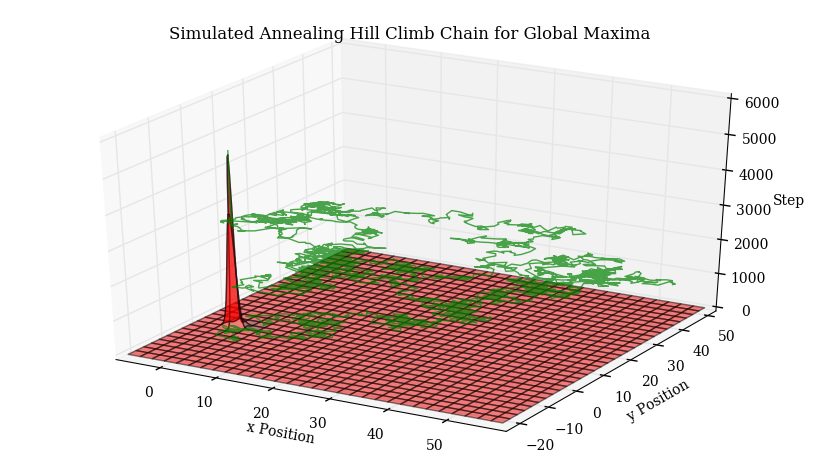

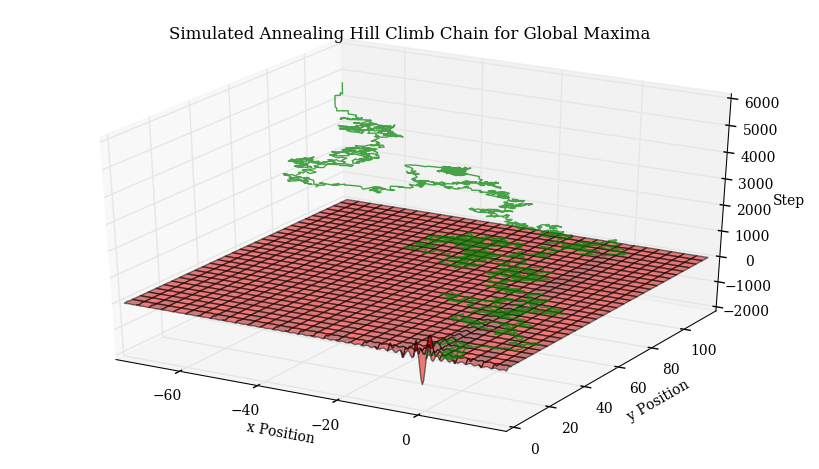

In [25]:
#now plot them
plot_full_chain_2D(chain1_2D,trials1_2D,sim_hill1_2D)
plot_full_chain_2D(chain2_2D,trials2_2D,sim_hill2_2D)

## Adding Back Periodic Boundaries

In [26]:
sim_hill1_2D.boundary=np.array([[-3,3],[-3,3]])
sim_hill2_2D.boundary=np.array([[-3,3],[-3,3]])

chain1_2D, trials1_2D = gather_full_chain(sim_hill1_2D)
chain2_2D, trials2_2D = gather_full_chain(sim_hill2_2D)

[0 0]
[0 0]


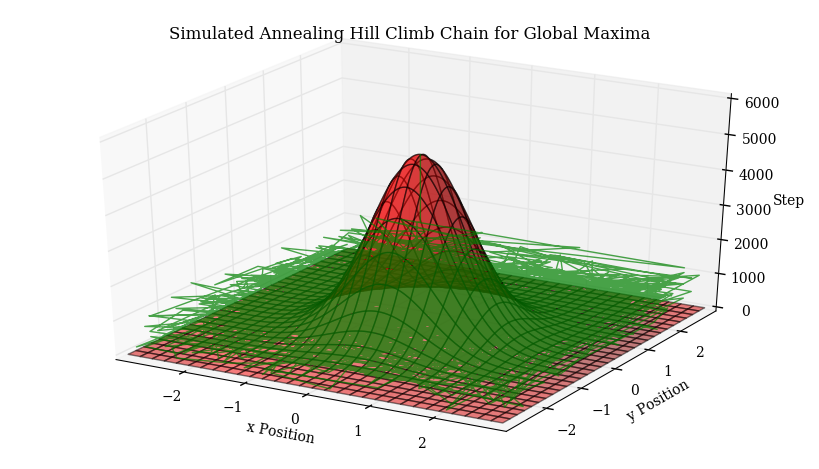

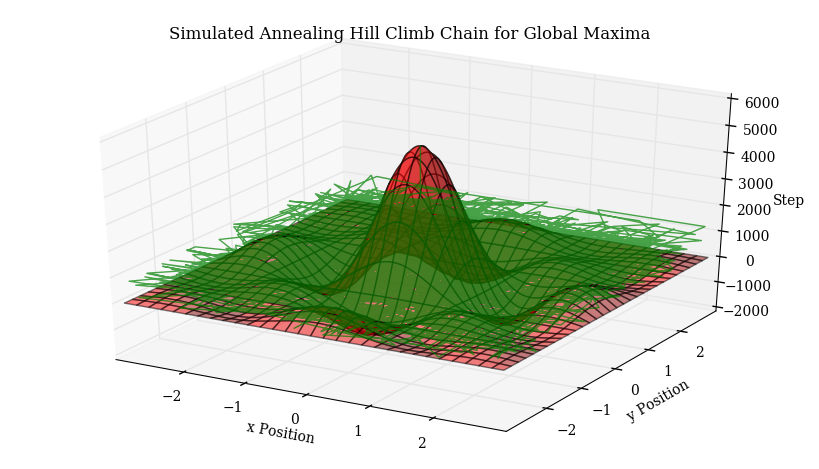

In [27]:
plot_full_chain_2D(chain1_2D,trials1_2D,sim_hill1_2D)
plot_full_chain_2D(chain2_2D,trials2_2D,sim_hill2_2D)